# Quora Insincere Questions Exploratory Data Analysis

We will explore the training data in order to come up with insights and a plan for modeling.

In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

np.random.seed(27)

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('Set2')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# load in data and print shape and head
raw_data = pd.read_csv('train.csv')
print(raw_data.shape)
raw_data.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
# print tail
raw_data.tail(5)

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


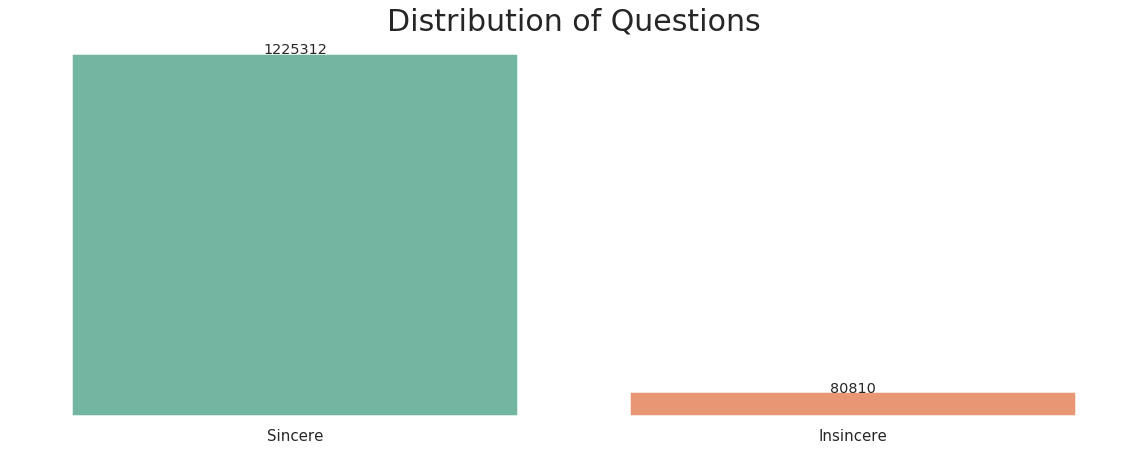

In [5]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(raw_data.target)
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Questions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [6]:
# print percentage of questions where target == 1
(len(raw_data.loc[raw_data.target==1])) / (len(raw_data.loc[raw_data.target == 0])) * 100

6.595054973753624

### Class Imbalance
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.  With just 6.6% of our dataset belonging to the target class, we can definitely have an imbalanced class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use.  Classification accuracy is defined as the number of correct predictions divided by total predictions times 100.  For example, if we simply predicted that all questions are sincere, we would get a classification acuracy score of 93%!

This competition uses the F1 score which balances precision and recall.
 - Precision is the number of true positives divided by all positive predictions.  Precision is also called Positive Predictive Value.  It is a measure of a classifier's exactness.  Low precision indicates a high number of false positives.
 - Recall is the number of true positives divided by the number of positive values in the test data.  Recall is also called Sensitivity or the True Positive Rate.  It is a measure of a classifier's completeness.  Low recall indicates a high number of false negatives.

In [7]:
# printing out a random sample of questions labeled insincere
import random

index = random.sample(raw_data.index[raw_data.target == 1].tolist(), 5)
for i in index:
    print(raw_data.iloc[i, 1])

How did the swamp drain Donald Trump?
What exactly are gun-supporting Americans scared of 24/7 that feel the need to strongly hold on to their guns? Nobody in the rest of the world feels so.
Does China innovate anything themselves, or just rely on stealing American’s intellectual property?
Why Mumbai people hate Pune people and rest Indians?
Why did the Muslim population increase by 5 times while the Hindu population increased by 3 times between 1951 and 2011? Is this trend dangerous?


In [8]:
# taking a small sample (with downsampling of majority class) of the training data to speed up processing
from sklearn.utils import resample

sincere = raw_data[raw_data.target == 0]
insincere = raw_data[raw_data.target == 1]

df = pd.concat([resample(sincere,
                     replace = False,
                     n_samples = len(insincere)), insincere])

In [10]:
# tokenize with spacy
nlp = spacy.load('en')

df['tokens'] = [nlp(text, disable=['ner']) for text in df.question_text]
df.sample(5)

,qid,question_text,target,tokens
1020074,c7e4692c467ee7a1f0d9,Is needing human interaction the same as narci...,0,"(Is, needing, human, interaction, the, same, a..."
1181596,e78cf52e9de4428952fd,Why Narendra Modi like Gujarat cadre IAS K. Ka...,0,"(Why, Narendra, Modi, like, Gujarat, cadre, IA..."
1196269,ea76fdc69a81bbf8f2be,How can an e-commerce business benefits from u...,0,"(How, can, an, e, -, commerce, business, benef..."
485161,5f02af0f5369af9139e1,Why are Indians on Quora so concerned about ot...,1,"(Why, are, Indians, on, Quora, so, concerned, ..."
536153,69050bdd43387b192628,Why are there so many homophobic aggressions b...,1,"(Why, are, there, so, many, homophobic, aggres..."


In [11]:
df['num_tokens'] = [len(token) for token in df.tokens]
df.sample(5)

,qid,question_text,target,tokens,num_tokens
440801,5662c432672586e2c788,I have recently gained interest in digital mar...,0,"(I, have, recently, gained, interest, in, digi...",34
1213574,eddbc178b01f81b009a0,What should people know in order to be a liber...,1,"(What, should, people, know, in, order, to, be...",20
992358,c27463bb6ac34fd4fd7a,Is Deja Vu something connected with parallel u...,0,"(Is, Deja, Vu, something, connected, with, par...",9
800730,9ce67a8ceb7440aa1a7d,Why do the men from Turkey always scam the wom...,1,"(Why, do, the, men, from, Turkey, always, scam...",14
1180412,e7510d13eb17cfa322b4,Why is tails called tails on a penny?,0,"(Why, is, tails, called, tails, on, a, penny, ?)",9


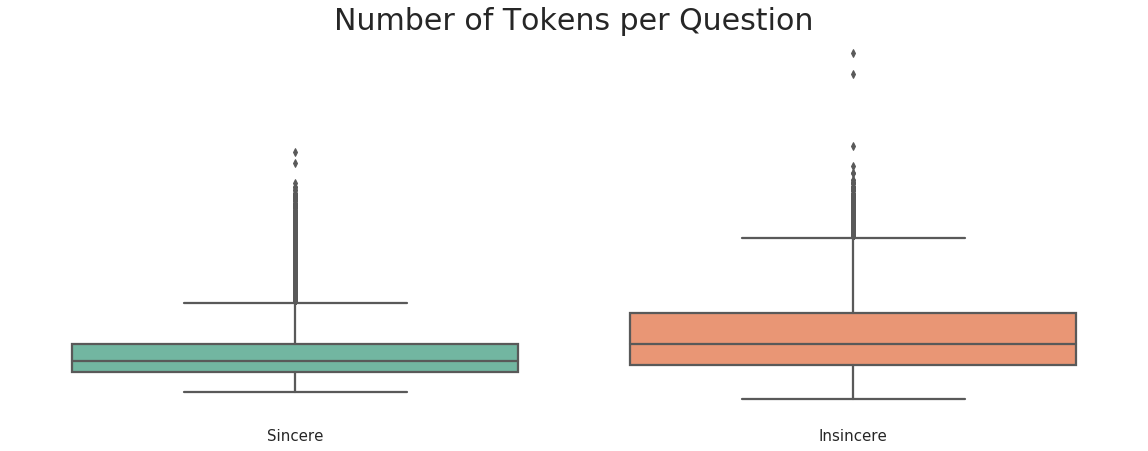

In [12]:
# using seaborns boxplot to visualize number of tokens per question
fig, ax = plt.subplots()
g = sns.boxplot(x=df.target, y=df.num_tokens)
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])



sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Tokens per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [13]:
## possibly come back to this? get base noun-phrase
list(df.iloc[0, 3].noun_chunks)

[What, apps, Linux, C]

In [14]:
# get number of sentences per question
print(list(df.iloc[0,3].sents))

sents = [list(x.sents) for x in df.tokens]
df['num_sents'] = [len(sent) for sent in sents]
df.sample(5)

[What is the best to learn developing apps on Linux using C?]


,qid,question_text,target,tokens,num_tokens,num_sents
225283,2c0e95c9632e2f3020ea,Are all ELSS plans tax savings?,0,"(Are, all, ELSS, plans, tax, savings, ?)",7,1
311374,3cfe97629235473da201,Which direction points towards Allah?,0,"(Which, direction, points, towards, Allah, ?)",6,1
482652,5e81d03be0f8bdc6e406,Approximately what minimum CAT 2017 percentile...,0,"(Approximately, what, minimum, CAT, 2017, perc...",28,1
809108,9e8e71eac26ede6aeb9d,Who do Pakistani construction workers in the M...,1,"(Who, do, Pakistani, construction, workers, in...",18,1
299784,3ab2e39a22aa2800e2de,How does it feel (for Indians) to live in USA ...,1,"(How, does, it, feel, (, for, Indians, ), to, ...",29,1


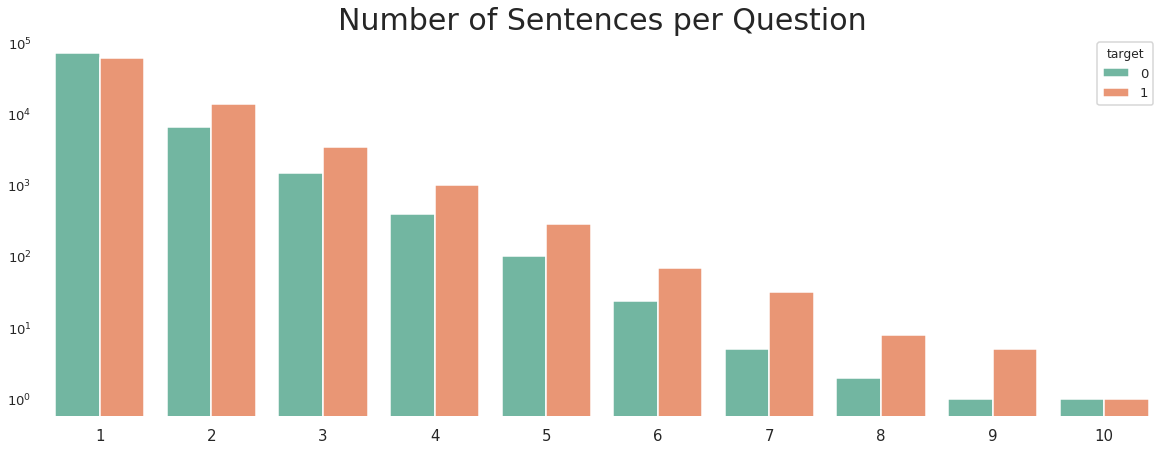

In [15]:
# plotting number of sentences per question
fig, ax = plt.subplots()
g = sns.countplot(df.num_sents, hue=df.target)
#g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# using log scale on y-axis so we can better see the questions with more sentences
ax.set(yscale='log')

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Sentences per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()